In [1]:
import json
import scipy.integrate as integ
%matplotlib inline
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

In [2]:
class Seat:
    def __init__(self,ID,x,y,theta):
        self.x=x
        self.y=y
        self.theta=theta
        self.ID=ID
        self.degVal=dict()
        self.degValX=list()
        self.degValY=list()
    def __compute_view_value__(self,ang,seat):
        from math import sqrt, sin, cos, atan, radians, degrees
        other_theta = (seat.theta + ang+90)%360
        #Rotate based on self perspective
        ang = radians((90-ang)%360)
        deltX   = seat.x-self.x
        deltY   = seat.y-self.y
        other_x = cos(ang)*deltX-sin(ang)*deltY
        other_y = sin(ang)*deltX+cos(ang)*deltY
        #If they're behind you, ignore.
        if other_y<-.01: return 0
        #Distance from self to other. Subtracts to simulate depth of field.
        other_dist=max(1,5-sqrt(deltX**2+deltY**2))
        #Find abs angle from direct line of sight
        try: peerAng = degrees(atan(abs(other_y/other_x)))-90
        except: peerAng=0
        #Normalize abs angle into a scaling factor
        minfact=.25
        maxAng=90/(1-minfact)
        deltang = (maxAng-abs(peerAng))/maxAng
        return other_dist*deltang
    def gradePosition(self,Seats):
        score = 0
        for deg in range(-80,81):
            currScore=0
            for seat in Seats.values():
                if seat.ID!=self.ID:
                    currScore += (self.__compute_view_value__((self.theta+deg)%360,seat))
            self.degVal[deg]=currScore
            score+=currScore*(150-abs(deg))/150
        return score/160
    def plotFOVVals(self,scale=False):
        points = sorted(((k,v) for k,v in self.degVal.items()), key=lambda x: x[0])
        x=list()
        y=list()
        for p in points:
            x.append(p[0])
            y.append(p[1]*(250-abs(p[0]*scale)))
        plt.plot(x,y)
        self.degValX=x
        self.degValY=y
        return x,y

/Users/suhas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


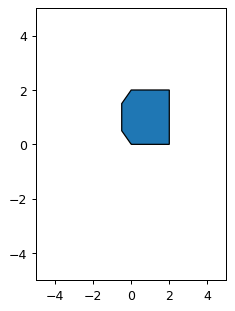

In [3]:
#Pull in data for a particular table
datasets = json.loads(open("table_data.json",'r').read())
table = 'dining-circle'
N = len(datasets[table].keys())
seats = {int(k):Seat(int(k),v[0],v[1],v[2]) for k,v in datasets[table].items()}
fig = plt.figure(5, dpi=90)
ax = fig.add_subplot(121)
coords = list((seat.x,seat.y) for l,seat in seats.items())
polygon = Polygon(coords)
if polygon.is_valid==False: polygon=polygon.convex_hull #todo concavity is tough
patch = PolygonPatch(polygon)
ax.add_patch(patch)
plt.xlim(-5,5)
plt.ylim(-5,5)
fig.show()

In [4]:
a=3
b=2
seats[a].__compute_view_value__((seats[a].theta+0)%360,seats[b])

1.875

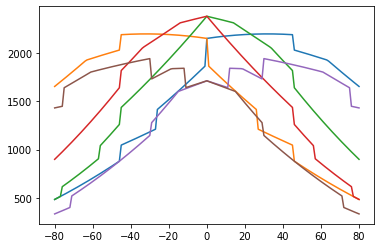

In [6]:
for i in range(N):
    seats[i].gradePosition(seats)
    x,y=seats[i].plotFOVVals(scale=True)